In [1]:
import sys  
sys.path.insert(0, './utils')
from pcqa_utils import *

import time, glob
from tqdm.notebook import tqdm
from numpy import linalg as LA
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from matplotlib.patches import Rectangle
from sklearn.metrics import mean_squared_error

# import warnings
# warnings.filterwarnings('error')

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def draw_mapping_result(grids, hull, minX, maxX, minY, maxY, width, height, draw_points):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111) 
    # draw the all rectangles
    for gx in np.arange (minX, maxX, width):
        for gy in np.arange (minY, maxY, height):
            ax.add_patch(Rectangle([gx, gy], width, height, color='green', alpha = 0.1))
    # draw points and convex
    ax.scatter(draw_points[:, 0], draw_points[:, 1], s = 2, c='b', label = 'origina lPoints')
    ax.plot(draw_points[hull.vertices,0], draw_points[hull.vertices,1], 'r--', lw=2)
    ax.plot(draw_points[hull.vertices[0],0], draw_points[hull.vertices[0],1], 'ro')
    plt.legend()
    plt.show()
    print (f'area: {hull.volume} and area of one grid is {width * height}')
    print (f'we have roughly {np.around(hull.volume / (width * height))} grids in the scanning area.')


# 1. PCQA

In [7]:
fileList = [
    './data/bunny.xyz'
]

jet_order = 3 # defacult is 3
searchPointSize = 256 # default is 256
gridnum_test_0 = int (np.around(np.sqrt( searchPointSize) - 1)) # 15
gridnum_test_1 = gridnum_test_0 - 2 # 13
gridnum_test_2 = gridnum_test_0 - 4 # 11
print (f'searchPointSize:{searchPointSize}, gridnum_test_0:{gridnum_test_0}')

stepName = [None] * 7
for filenameIndice, filename in enumerate(tqdm(fileList)):
    filename = filename[:filename.find('.xyz')]
    print (f'#{filenameIndice}/{len(fileList)} filename: {filename}')
    data = np.loadtxt(f'{filename}_order{jet_order}_normal_beta.txt')
    # x y z nx ny nz betas (0 - 9)
    rawPoints = data[:, 0:3]
    normals = data[:, 3:6]
    betas = data[:, 6:]
    print (f'rawPoints data format: {rawPoints.shape}')
    print (f'normals data format: {normals.shape}')
    print (f'betas data format: {betas.shape}')

    unitPoints = preprocess(rawPoints)
    resList, totalTime = [], []
    kdtree = cKDTree(unitPoints, leafsize = 10, balanced_tree = False)

    # evenly sampled by 12
    skipNum, totalN = 12, unitPoints.shape[0]
    sampledIndices = np.linspace(0, totalN - 1, int(totalN / skipNum)).astype(int)
    
    # sampledIndices = np.array_split(sampledIndices, 5)[0]
    print (f'{len(sampledIndices)} points will be calculated, it takes {100*np.around(len(sampledIndices) / totalN, 3)}%')

    alphaList, skipIndices = [], []
    for indice, i in enumerate(tqdm(sampledIndices)):
        # 1. Searching neighbor points
        stepName[1] = 'Searching neighbor points'
        timeStart = time.time()
        partPoints, _, rad = processPart (kdtree, i, unitPoints, searchPointSize)
        partPoints = partPoints.numpy().T
        alpha, _ = averageDisPoints(partPoints, searchK = 2)
        # np.savetxt('./tmpBug.xyz', partPoints, fmt='%1.6f')
        timeSeg1 = time.time() - timeStart
        timeStart = time.time()
        
        # 2. Obtain Fitting Results
        stepName[2] = 'Obtain Fitting Results'
        n_est = normals[i, :]
        beta =  betas[i, :]
        # print (f'#{i} p:{p} n_est: {n_est} beta:{beta}')
        timeSeg2 = time.time() - timeStart
        timeStart = time.time()

        # 3. Generate Points by the Fitting Results
        stepName[3] = 'Generate Points by the Fitting Results'
        minP, maxP = bounding_box_naive(partPoints)
        synPartPoints = generateDataByParameter(beta, minP[0], maxP[0], minP[1], maxP[1], jet_order = jet_order)
        tree = cKDTree(synPartPoints, leafsize = 10, balanced_tree=False)
        nearestPoints, nearestIndex, nearestDis = [], [], []
        for pp in partPoints:
            dd, ii = tree.query(pp, k=1)
            nearestPoints.append(synPartPoints[ii])
            nearestIndex.append(ii)
            nearestDis.append(dd)
        if np.mean(nearestDis) > 1.5 * alpha:
            skipIndices.append(i)
            continue
        nearestPoints = np.asarray(nearestPoints)
        # print (f'info: nearestPoints: {nearestPoints.shape}')
        # print (f'nearestPoints mrse: {np.sqrt(np.sum((nearestPoints - partPoints) * (nearestPoints - partPoints)))}')
        # #Original，generated Points and the nearest points on the generated points
        # showPoints ([partPoints, synPartPoints, nearestPoints])
        # showPoints ([partPoints, nearestPoints])
        # break
        timeSeg3 = time.time() - timeStart
        timeStart = time.time()

        # 4. Triangulate the Generated Points
        stepName[4] = 'Triangulate the Generated Point'
        tri = Delaunay(synPartPoints[:, 0:2])
        faces = tri.simplices
        # showMesh(synPartPoints, faces)
        timeSeg4 = time.time() - timeStart
        timeStart = time.time()
        
        
        # 5. Calculate the Distance and Angular 
        stepName[5] = 'Calculate the Distance and Angular'
        distances = calculateDistancesMesh(synPartPoints, faces,
                                   np.array(nearestIndex[:1]), np.array(nearestIndex[1:]),
                                   showPath = False)
        vecs = nearestPoints[1:] - nearestPoints[0]
        pThetas = calculateAngleOnSurface(vecs, n_est)

        distributionPoints = pol2cart(distances, pThetas)
        meanDistributionP = np.mean(distributionPoints, axis = 0)
        # plt.scatter(distributionPoints[:, 0], distributionPoints[:, 1], s = 2)
        # plt.scatter(meanDistributionP[0], meanDistributionP[1], s = 20, c='r')
        # plt.scatter(0, 0, s = 20, c='g')
        # plt.annotate('', xy=(meanDistributionP[0], meanDistributionP[1]), 
        #              xytext=(0,0), arrowprops={'width': 2, 'headwidth': 8, 'headlength': 5})
        # plt.show()
        timeSeg5 = time.time() - timeStart
        timeStart = time.time()

        # 6. Calculate the Quality of Current Point
        stepName[6] = 'Calculate the Quality of Current Point'
        qualityListPerPoint = []
        for gridNum in [gridnum_test_0, gridnum_test_1, gridnum_test_2]: # Here calculate 3 grid-based quality
            minX, maxX = np.min(distributionPoints[:, 0]), np.max(distributionPoints[:, 0])
            minY, maxY = np.min(distributionPoints[:, 1]), np.max(distributionPoints[:, 1])
            width, height = (maxX - minX) / gridNum, (maxY - minY) / gridNum
            # transform all distributed points
            MFrame = np.array([
                [1, 0, -minX],
                [0, 1, -minY],
                [0, 0, 1]]
            ).reshape(3,3)
            grids = np.zeros((gridNum,gridNum))
            gridPoints = np.concatenate([distributionPoints.astype(np.float64), 
                                     np.ones((distributionPoints.shape[0], 1))], axis = 1)
            t_gridPoints = np.dot(MFrame, gridPoints.T).T
            for gp in t_gridPoints:
                gx, gy = gp[0], gp[1]
                gridRow = gridNum - 1  if int(gy/height) >= gridNum else int(gy/height)
                gridCol = gridNum - 1 if int(gx/width) >= gridNum else int(gx/width)
                grids[gridRow, gridCol] += 1
            timeSeg6 = time.time() - timeStart
            timeStart = time.time()
            hull = ConvexHull(gridPoints[:, 0:2])
            nonZeroRatio = np.count_nonzero(grids) / (hull.volume / (width * height))
            nonZeroRatio = 1 if nonZeroRatio > 1 else nonZeroRatio # [0,1] # offset, can be ignored here
            distance = LA.norm(meanDistributionP) 
            quality = nonZeroRatio * (alpha) # alpha is the average value of nearest distances in 'partPoitns'
            qualityListPerPoint.append(1/quality)
            # draw_mapping_result(grids, hull, minX, maxX, minY, maxY, width, height, gridPoints)
        resList.append(qualityListPerPoint)
        timeSeg6 = time.time() - timeStart
        timeStart = time.time()
        totalTime.append([timeSeg1, timeSeg2, timeSeg3, timeSeg4, timeSeg5, timeSeg6])
        
    arrResList = np.array(resList) # should be -1 x 3
    print (f'{len(skipIndices)}/{len(sampledIndices)} are skipped')
    remainIndices = list(set(sampledIndices).difference(set(skipIndices)))
    tmp = f'{filename}_quality_score_ours.txt'
    np.savetxt(tmp, np.concatenate([rawPoints[remainIndices], arrResList], axis = 1) , fmt='%1.6f')
    print (f'quality score file save to {tmp}')


searchPointSize:256, gridnum_test_0:15


  0%|          | 0/1 [00:00<?, ?it/s]

#0/1 filename: ./data/bunny
rawPoints data format: (35947, 3)
normals data format: (35947, 3)
betas data format: (35947, 10)
2995 points will be calculated, it takes 8.3%


  0%|          | 0/2995 [00:00<?, ?it/s]

538/2995 are skipped
quality score file save to ./data/bunny_quality_score_ours.txt


# 2. Results Analysis

In [4]:
stdValue, meanValue = np.std(arrResList, axis = 0), np.mean(arrResList, axis = 0)
print (f'{stdValue}\n{stdValue/meanValue}\n{meanValue}')

[8.24686195 4.98223779 4.13733623]
[0.07020792 0.04334681 0.03617533]
[117.46342083 114.93898341 114.3689938 ]


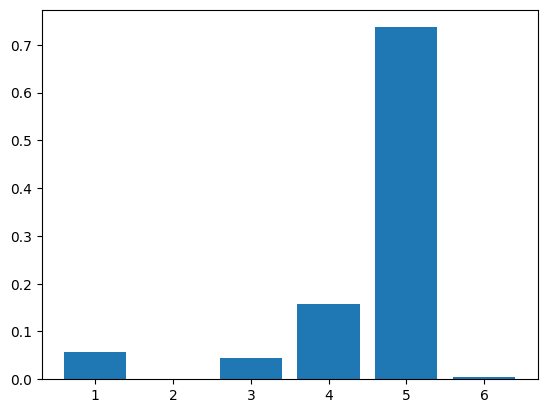

0 : Searching neighbor points (6.0%)
1 : Obtain Fitting Results (0.0%)
2 : Generate Points by the Fitting Results (4.0%)
3 : Triangulate the Generated Point (16.0%)
4 : Calculate the Distance and Angular (74.0%)
5 : Calculate the Quality of Current Point (0.0%)


In [5]:
meanList = np.mean(np.asarray(totalTime), axis=0)
meanList = meanList / np.sum(meanList)

stepIndex = ['1', '2', '3', '4', '5', '6']
plt.bar(stepIndex, meanList)
plt.show()

for i, v in enumerate(stepIndex):
    print (f'{i} : {stepName[i+1]} ({100*np.around(meanList[i], 2)}%)')